In [1]:
# %matplotlib qt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
def txt_to_df(data_files, freqs):
    dfs = {}
    for freq, filename in zip(freqs, data_files):
        # print(f"Reading {freq}, {filename}...")
        with open(filename, 'r') as file:
            content = file.read()
            content = content.replace('"', '')
        
        with open(filename, 'w') as file:
            file.write(content)

        df = pd.read_csv(filename, delimiter=',')
    
        # print("Number of NaNs in each column:")
        # print(df.isnull().sum())
        df = df.dropna()
        
        df['Error'] = df[' Error']
        df['Target angle'] = df[' Target angle']
        df.drop(columns=[' Error', ' Target angle'], inplace=True)

        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col], errors='raise')
            except ValueError as e:
                # print(f"\nOh Oh! Conversion failed in column: {col}, Error: {e}\n")
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # print("Number of NaNs in each column:")
        # print(df.isnull().sum())
        df = df.dropna()
        
        dfs[freq] = df

    return dfs

In [3]:

def sine_wave(t, A, phase, offset, freq):
    return A * np.sin(2 * np.pi * freq * t + phase) + offset

def get_rms_amps(data, freq, ax_target=None, ax_error=None, plot=False):
    assert (plot and (ax_target or ax_error)) or not plot, "Please provide axes for plotting"

    time_ms = data['Run time']
    time_ms = pd.to_numeric(time_ms, errors='raise')
    time_s = time_ms / 1000

    error = data['Error']
    target_angle = data['Target angle']

    params_target, _ = curve_fit(
        lambda t, A, phase, offset: sine_wave(t, A, phase, offset, freq), time_s, target_angle, p0=[30, 0, 0]
        )
    A_target, phase_target, offset_target = params_target
    target_fit = sine_wave(time_s, A_target, phase_target, offset_target, freq)
                
    ### I'm so sorry for this code. I know this can be done better but hey, it works!
    if max(target_fit) >= 30:
        start_index = np.argmax(target_fit > 30)
    elif max(target_fit) >= 27:
        start_index = np.argmax(target_fit >= 27)
    elif max(target_fit) >= 25:
        start_index = np.argmax(target_fit >= 25)
    elif max(target_fit) >= 24:
        start_index = np.argmax(target_fit >= 24)
    elif max(target_fit) >= 23:
        start_index = np.argmax(target_fit >= 23)
    elif max(target_fit) >= 22:
        start_index = np.argmax(target_fit >= 22)
    elif max(target_fit) >= 21: 
        start_index = np.argmax(target_fit >= 21)
    elif max(target_fit) >= 20:
        start_index = np.argmax(target_fit >= 20)
    elif max(target_fit) >= 19:
        start_index = np.argmax(target_fit >= 19)
    elif max(target_fit) >= 18:
        start_index = np.argmax(target_fit >= 18)
    
    if freq == 0.6:
        start_index = 0

    angle_range = 60
    cycles = 10 if freq > 0.2 or freq in [0.01, 0.1] else 5
    points_per_wave = 500
    total_points = cycles * points_per_wave
    t_perfect = np.linspace(0, cycles / freq, total_points)
    perfect_wave = (angle_range/2) * np.cos(2 * np.pi * freq * t_perfect)
    t_perfect_shifted = t_perfect + time_s[start_index]

    params_perfect, _ = curve_fit(
        lambda t, A, phase, offset: sine_wave(t, A, phase, offset, freq), t_perfect_shifted, perfect_wave, p0=[30, 0, 0]
        )
    A_perfect, phase_perfect, offset_perfect = params_perfect
    perfect_fit = sine_wave(t_perfect_shifted, A_perfect, phase_perfect, offset_perfect, freq)
    
    phase_diff_rad = phase_target - phase_perfect
    phase_diff_deg = phase_diff_rad * (180 / np.pi)

    if plot and ax_target:
        ax_target.plot(time_s, target_angle, label='Target Angle')
        # ax_target.plot(time_s, target_fit, label='Target Fit', linestyle='--')
        # ax_target.plot(t_perfect_shifted, perfect_wave, label='Perfect Angle', alpha=0.8)
        ax_target.set_title(f"Target Angle at {freq}Hz", fontsize=6)
        ax_target.tick_params(axis="both", labelsize=6)

    if plot and ax_error:
        ax_error.plot(time_s, error, label='Error')
        # ax_error.plot(time_s, error_fit, label='Error Fit')
        ax_error.set_title(f"Error at {freq}Hz", fontsize=6)
        ax_error.tick_params(axis="both", labelsize=6)
        ax_error.legend(fontsize=6, loc='lower right')

    rms_target = np.mean(target_angle**2)**0.5
    rms_error = np.mean(error**2)**0.5

    return rms_target, rms_error, phase_diff_deg





In [4]:
def plot_rms(rms_targets, rms_errors, freqs, save_suff=""):
    fig, ax = plt.subplots()
    ax.plot(freqs, rms_targets, label='Target RMS', linestyle='-', marker='x')
    ax.plot(freqs, rms_errors, label='Error RMS', linestyle='-', marker='x')
    ax.axvline(x=0.15, color='r', linestyle='--')
    ax.set_xlabel('Frequency (Hz)', fontsize=20)
    ax.set_ylabel('Amplitude (degrees)', fontsize=20)
    ax.set_title('(a) RMS Amplitude vs Frequency', fontsize=20)
    ax.tick_params(axis="both", labelsize=20)
    ax.legend(fontsize=20, loc='upper right')
    # plt.grid()
    plt.tight_layout()
    plt.savefig(f"figures/RMS_vs_f{save_suff}.pdf")
    plt.show()

In [5]:
def bode_plot(gains, phases, freqs, save_suff=""):
    gains = gains[0]
    # gain_db = 20 * np.log10(gains)
    plt.figure()

    # Magnitude plot
    plt.plot(freqs, gains, 'x-')
    plt.axvline(x=0.15, color='r', linestyle='--')
    plt.title("(b) Gain vs Frequency", fontsize=20)
    plt.ylabel("Gain", fontsize=20)
    plt.xlabel("Frequency (Hz)", fontsize=20)
    plt.tick_params(axis="both", labelsize=20)
    # plt.grid()
    plt.tight_layout()
    plt.savefig(f"figures/gain_vs_f{save_suff}.pdf")

    plt.figure()
    plt.axvline(x=0.15, color='r', linestyle='--')
    plt.plot(freqs, phases, 'x-')
    plt.title("(c) Phase vs Frequency", fontsize=20)
    plt.ylabel("Phase (degrees)", fontsize=20)
    plt.xlabel("Frequency (Hz)", fontsize=20)
    plt.tick_params(axis="both", labelsize=20)
    # plt.grid()
    plt.tight_layout()
    plt.savefig(f"figures/phase_vs_f{save_suff}.pdf")

In [ ]:
def compare_pid(data1, data2):
    gains, phases, freqs = data1
    new_gains, new_phases, new_freqs = data2
    gains = gains[0]
    new_gains = new_gains[0]
    freqs = freqs[2:]
    gains = gains[2:]
    phases = phases[2:]

    plt.figure()
    # Magnitude plot
    plt.plot(new_freqs, new_gains, 'x-', label='Adjusted PID')
    plt.plot(freqs, gains, linestyle='--', color="grey", label='Default PID')
    plt.axvline(x=0.4, color='r', linestyle='--')
    # plt.semilogx(freqs, gains, linestyle='--', color="grey", label='Default PID')
    plt.title("(a) Gain vs Frequency", fontsize=16)
    plt.ylabel("Gain", fontsize=16)
    plt.xlabel("Frequency (Hz)", fontsize=16)
    plt.legend(fontsize=16)
    plt.tick_params(axis="both", labelsize=16)
    # plt.grid()
    plt.tight_layout()
    plt.savefig("figures/compare_gain.pdf")

    plt.figure()
    plt.plot(new_freqs, new_phases, 'x-', label='Adjusted PID')
    plt.plot(freqs, phases, linestyle='--', color="grey", label='Default PID')
    plt.axvline(x=0.4, color='r', linestyle='--')
    # plt.semilogx(freqs, phases, linestyle='--', color="grey", label='Default PID')
    plt.title("(b) Phase vs Frequency", fontsize=16)
    plt.ylabel("Phase (degrees)", fontsize=16)
    plt.xlabel("Frequency (Hz)", fontsize=16)
    plt.legend(fontsize=16)
    plt.tick_params(axis="both", labelsize=16)
    # plt.grid()
    plt.tight_layout()
    plt.savefig("figures/compare_phase.pdf")


In [ ]:
def plot_data_distribution(data):
    frequencies_of_interest = [0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.2, 0.3, 0.4, 0.5, 0.6]
    data = {key: value for key, value in data.items() if key in frequencies_of_interest}

    # Prepare data for boxplot
    df = pd.concat([
        pd.DataFrame({'frequency': freq, 'value': df['Target angle']})
        for freq, df in data.items()
    ], ignore_index=True)

    # Calculate means for each frequency
    means = {freq: (df['Target angle']).mean() for freq, df in data.items()}

    # Plot boxplot
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(data=df, x='frequency', y='value', width=0.5, palette='pastel')

    # Plot means - Align with x-tick positions
    xtick_positions = [i for i, freq in enumerate(frequencies_of_interest) if freq in means]
    mean_values = [means[freq] for freq in frequencies_of_interest if freq in means]

    plt.plot(xtick_positions, mean_values, marker='o', linestyle='-', color='k', label='Mean', alpha=0.6)

    # Customizations
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.title('Target Angle Distributions by Frequency', fontsize=14)
    # plt.tick_params(axis="both", labelsize=20)
    plt.ylabel('Target Angle (degrees)', fontsize=14)
    plt.xlabel('Frequency (Hz)', fontsize=14)
    
    plt.legend(fontsize=14)

In [8]:
def plot_select_target_angles(data):
    d1 = data[0.03]['Target angle']
    d2 = data[0.4]['Target angle']

    plt.figure()
    plt.title('Target Angle at 0.03Hz', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.ylabel('Target Angle (degrees)', fontsize=20)
    plt.tick_params(axis="both", labelsize=20)
    plt.plot(d1, label='0.03Hz')
    plt.tight_layout()

    plt.figure()
    plt.title('Target Angle at 0.4Hz', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.ylabel('Target Angle (degrees)', fontsize=20)
    plt.tick_params(axis="both", labelsize=20)
    plt.plot(d2, label='0.4Hz')
    plt.tight_layout()

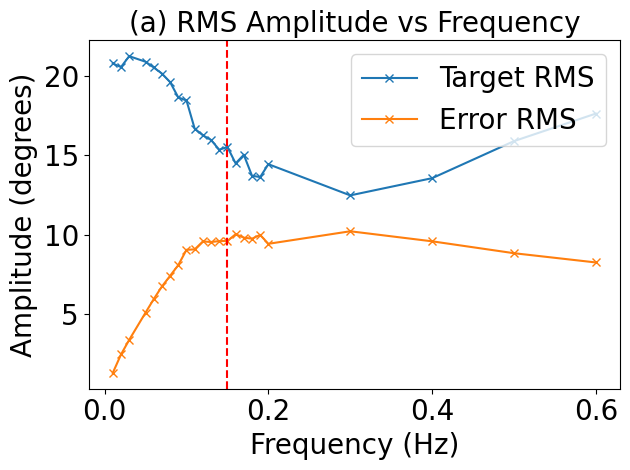


NEW PID


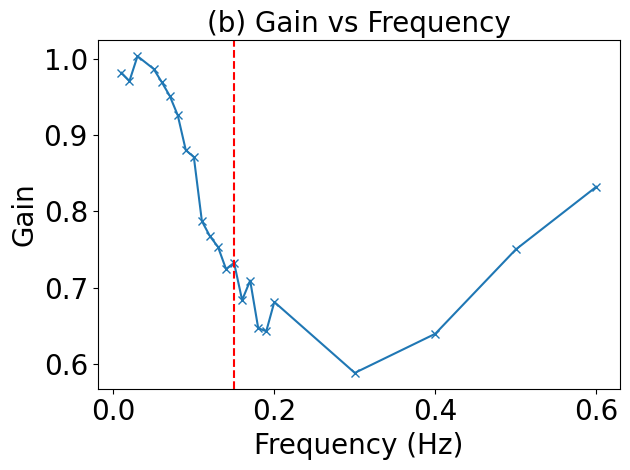

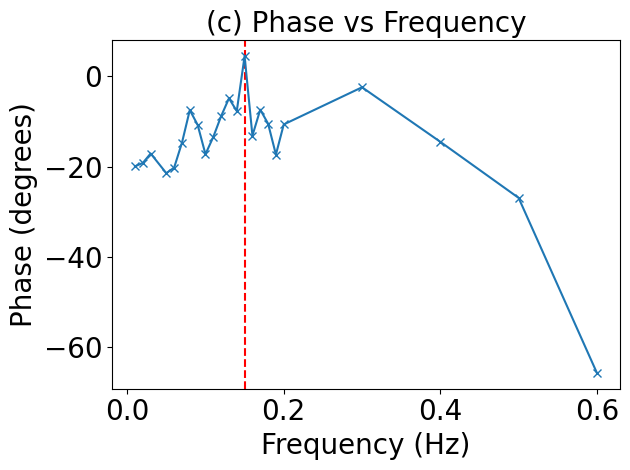

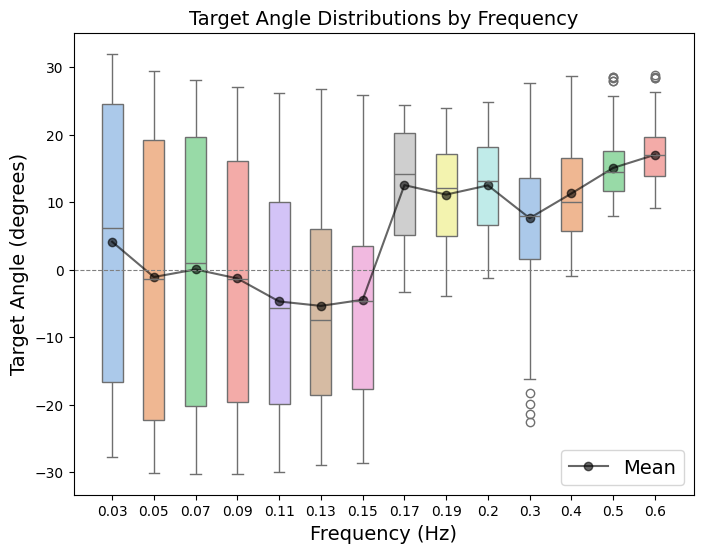

In [9]:
def run(data_files, freqs, save_suff="idk"):
    plt.close('all')
    assert len(data_files) == len(freqs), "Bro, please"

    data = txt_to_df(data_files, freqs)
    rms_targets = []
    rms_errors = []
    phase_diffs = []
    # fig, axs = plt.subplots(int(np.ceil(len(freqs)/2)), 4, figsize=(12, 3 * len(freqs)))

    for i, (freq, df) in enumerate(data.items()):
        row = i // 2
        col = i % 2
        if i % 2 == 1:
            col += 1
        # rms_target, rms_error, phase_diff = get_rms_amps(df, float(freq), axs[row, col], axs[row, col+1], plot=True)
        rms_target, rms_error, phase_diff = get_rms_amps(df, float(freq))
        rms_targets.append(rms_target)
        rms_errors.append(rms_error)
        phase_diffs.append(phase_diff)

    # plt.tight_layout()
    plot_rms(rms_targets, rms_errors, freqs, save_suff)
    gains = [np.array(rms_targets)/(30/2**0.5)]
    bode_plot(gains, phase_diffs, freqs, save_suff)
    plot_data_distribution(data)
    # plot_select_target_angles(data)

    return gains, phase_diffs, freqs

# Obtaining and sorting data files by frequency
unsorted_data_files = os.listdir("data/stock_pid")
unsorted_freqs = [float(f.split('_')[1].split('Hz')[0]) for f in unsorted_data_files]
combined = [(freq, file) for freq, file in sorted(zip(unsorted_freqs, unsorted_data_files))]
freqs, data_files = zip(*combined)
data_files = [f"data/stock_pid/{f}" for f in data_files]

# Better PID: Obtaining and sorting data files by frequency 
new_unsorted_data_files = os.listdir("data/better_pid")
new_unsorted_freqs = [float(f.split('_')[-1].split('Hz')[0]) for f in new_unsorted_data_files]
new_combined = [(freq, file) for freq, file in sorted(zip(new_unsorted_freqs, new_unsorted_data_files))]
new_freqs, new_data_files = zip(*new_combined)
new_data_files = [f"data/better_pid/{f}" for f in new_data_files]

output = run(data_files, freqs, save_suff="")
print("\nNEW PID")
# new_output = run(new_data_files, new_freqs, save_suff="_adj")
# compare_pid(output, new_output)